# Presentación y referencias

Para el entrenamiento de un modelo de machine learning existen diferentes técnicas aplicables según los datos que se posean, siendo la forma más común de entrenamiento aquella supervisada, en que explícitamente se indíca a qué grupo o etiqueta pertenece un dato para que el modelo aprenda. Sin embargo, este tipo de entrenamiento puede ser no aplicable si, por ejemplo, el conjunto de datos no posee etiquetas explícitas o se desean analizar tendencias en datos recopilados, siendo necesario para estos casos el uso de metodologías como clustering: entregar el conjunto a un algoritmo que sea capaz de identificar similitudes entre los diferentes puntos y asignarlos a grupos según estén más cerca unos de otros.

Como ejemplo, se utilizará el siguiente caso: Una plataforma para subir videos desea detectar qué juego popular del momento es el que aparece en un video, de modo que pueda ser asignado automáticamente a su categoría correspondiente para que pueda ser encontrado por usuarios interesados en conocer sobre ese videojuego en particular. Para ello, se cuenta con imágenes de gameplay de cada uno de los juegos a considerar y se debe preparar un modelo capaz de detectar a qué videojuego pertenece una imagen dada, verificando cuáles algoritmos de los que existen poseen la mejor precisión.

## Referencias
- Definición: https://developers.google.com/machine-learning/clustering/overview
- Dataset: https://www.kaggle.com/datasets/aditmagotra/gameplay-images




# Ejecución de este Notebook
El presente notebook está pensado para ser ejecutado en una instancia de Google Colab con GPU debido al gran tamaño de su dataset.

In [ ]:
try:
    import google.colab
        
except ImportError:
    print("Este notebook debería ser ejecutado en Google Collab")


# Problema
Se posee un conjunto de datos compuesto por imágenes de diferentes videojuegos populares como Minecraft, Fortnite, Apex Legends, Genshin Impact, entre otros, originalmente separados por carpetas según el juego. Se desea utilizar estas imágenes para el entrenamiento y validación de modelos de aprendizaje utilizando diferentes técnicas de clustering para distinguir los diferentes juegos.

Para ello, será necesario:
1. Reunir las imágenes bajo una sola carpeta, esto a fin de simular el tipo de entrenamiento sin etiquetas. Para fines de aprendizaje se mantendrán indicadores como nombre de archivo para saber a qué juego pertenece una imagen, pero esto no será utilizado en el proceso de entrenamiento.
2. Analizar el set de datos, separando imágenes de entrenamiento y de prueba del modelo.
3. Transformar las imágenes: Una imagen no puede ser directamente utilizada para entrenar un modelo, por lo que se requiere de una conversión especial a valores utilizables.
4. Entrenar modelo utilizando diferentes técnicas.
5. Comprobar métricas de modelos entrenados.

## Descargar dataset
Para descargar el dataset se utilizará la API de Kaggle, para facilitar el uso de este notebook en Colab.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aditmagotra/gameplay-images")

print("Path to dataset files:", path)

100%|██████████| 2.51G/2.51G [00:33<00:00, 80.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aditmagotra/gameplay-images/versions/1


In [2]:
import os
os.chdir(path)

## EDA
Para comenzar con el proceso se debe, inicialmente, conocer el set de datos con el que se trabaja. Para ello, se comenzará importando los archivos a utilizar y a visualizarlos.

Inicialmente se lee el directorio del dataset, dejando como metadatos a qué juego pertenece la imagen, para posterior verificación.

In [3]:
import os
folder = "Dataset"
file_paths=[]

games = []
number_of_games=0

for root, _, files in os.walk(folder):
    divided_root_path=root.split("/")
    if len(divided_root_path)>1:
        number_of_games+=1
    for file_path in files:
        if file_path.endswith((".png", ".jpg")):
            path = os.path.join(root, file_path)
            file_paths.append(path)
            games.append(divided_root_path[1])


number_of_games

10

Una vez obtenidas las imágenes pueden ser previsualizadas para saber cómo son algunas de las imágenes con las que se trata.

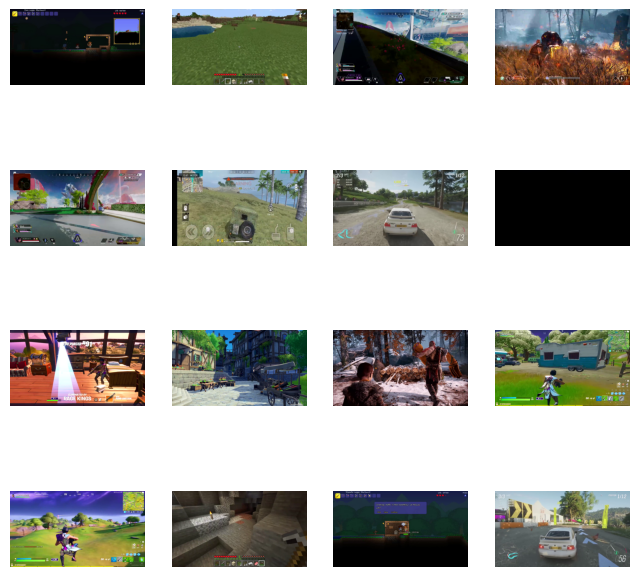

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def show_samples(image_paths, n=9):
    idx = np.random.choice(len(image_paths), n, replace=False)
    plt.figure(figsize=(8, 8))
    for i, i_img in enumerate(idx):
        image_path=image_paths[i_img]
        img = np.array(Image.open(image_path).convert("RGB"))
        plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i + 1)
        plt.imshow(img.astype("uint8"))
        plt.axis("off")
    plt.show()

# Example usage
show_samples(file_paths,16)

## Separación de entrenamiento y de prueba
Para separar datos para el entranamiento del modelo y de prueba se puede utilizar la herramienta split de sklearn.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, metadata_train, metadata_test = train_test_split(
file_paths, games, test_size=0.3, random_state=42)

In [6]:
print(len(X_train))
for path,game in zip(X_train,metadata_train):
    print(path,game)

7000
Dataset/God of War/image_394.png God of War
Dataset/Minecraft/image_613.png Minecraft
Dataset/Fortnite/image_491.png Fortnite
Dataset/Forza Horizon/image_304.png Forza Horizon
Dataset/Terraria/image_706.png Terraria
Dataset/Terraria/image_711.png Terraria
Dataset/Genshin Impact/image_339.png Genshin Impact
Dataset/Free Fire/image_821.png Free Fire
Dataset/Among Us/image_373.png Among Us
Dataset/Apex Legends/image_134.png Apex Legends
Dataset/Terraria/image_929.png Terraria
Dataset/Terraria/image_379.png Terraria
Dataset/Genshin Impact/image_898.png Genshin Impact
Dataset/Minecraft/image_605.png Minecraft
Dataset/Free Fire/image_881.png Free Fire
Dataset/Forza Horizon/image_524.png Forza Horizon
Dataset/Among Us/image_553.png Among Us
Dataset/God of War/image_486.png God of War
Dataset/Forza Horizon/image_25.png Forza Horizon
Dataset/Apex Legends/image_200.png Apex Legends
Dataset/Free Fire/image_882.png Free Fire
Dataset/Terraria/image_32.png Terraria
Dataset/Among Us/image_291.pn

## Embedding
Las imágenes por sí solas, a pesar de que son significativas para un humano, no pueden ser utilizadas para entrenamiento. El análisis pixel a pixel no es efectivo para el aprendizaje, por lo que se utilizan técnicas como el **embedding**: pasar la imagen por un modelo especializado capaz de extraer información vectorial de la imagen que podrá ser utilizada para entrenar.

In [7]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch, os


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model=model.to(device)
device


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

'cuda'

In [9]:
def get_embedding(path):
    img = Image.open(path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = model.get_image_features(**inputs)
    return emb.cpu().squeeze().numpy()

In [10]:
import numpy as np

embeddings_train=[get_embedding(path) for path in X_train]
embeddings_train=np.stack(embeddings_train)

## Entrenar modelo
Para entrenar un modelo existen diferentes algoritmos a utilizar, adaptados a diferentes finalidades. Entre ellos está KMeans, cuyo parámetro principal es la cantidad de clusters a encontrar: a partir de este parámetro intentará, de la forma que sea, encontrar esa N cantidad de clusters que se indique, sean significativos o no. Como en este caso es conocida la cantidad de juegos, puede ser un algoritmo de utilidad.

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=number_of_games, random_state=482)
labels = kmeans.fit_predict(embeddings_train)

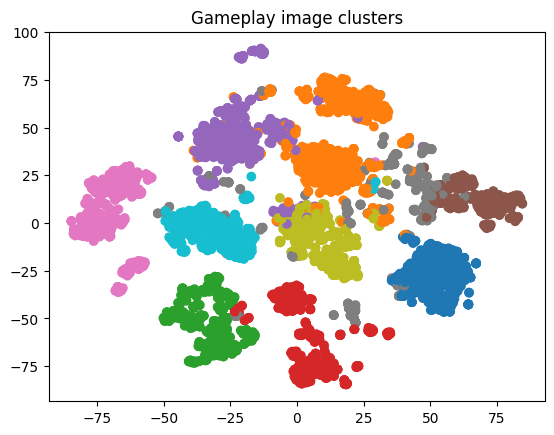

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

proj = TSNE(n_components=2, random_state=482).fit_transform(embeddings_train)
plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap="tab10")
plt.title("Gameplay image clusters")
plt.show()

In [20]:
for cluster in range(number_of_games):
    print(f"Cluster {cluster}:")
    game_occurrence_map={}
    for file_path, lbl,real in zip(X_train,labels,metadata_train):
        if lbl == cluster:
            occurrences=game_occurrence_map.get(real,0)+1
            game_occurrence_map[real]=occurrences
            #print(" ", file_path, " real: ", real)

    for key,number in game_occurrence_map.items():
        print(f"\t {key}: {number}")
    print("")

Cluster 0:
	 God of War: 707
	 Free Fire: 6

Cluster 1:
	 Apex Legends: 634
	 Free Fire: 527
	 Genshin Impact: 23
	 Fortnite: 5
	 God of War: 4
	 Forza Horizon: 18
	 Roblox: 1

Cluster 2:
	 Terraria: 686

Cluster 3:
	 Among Us: 638
	 Terraria: 15
	 God of War: 1

Cluster 4:
	 Fortnite: 689
	 Free Fire: 119
	 Genshin Impact: 71
	 Apex Legends: 2
	 Forza Horizon: 1

Cluster 5:
	 Forza Horizon: 467
	 Free Fire: 2

Cluster 6:
	 Minecraft: 712
	 Apex Legends: 1

Cluster 7:
	 Forza Horizon: 206
	 God of War: 23
	 Apex Legends: 44
	 Among Us: 42
	 Terraria: 9
	 Roblox: 14
	 Fortnite: 10
	 Free Fire: 17
	 Genshin Impact: 26

Cluster 8:
	 Genshin Impact: 577
	 Apex Legends: 24
	 Free Fire: 10
	 Fortnite: 2

Cluster 9:
	 Roblox: 661
	 Free Fire: 1
	 Apex Legends: 3
	 Fortnite: 2



In [16]:
import numpy as np

embeddings_test=[get_embedding(path) for path in X_test]
embeddings_test=np.stack(embeddings_test)

In [17]:
labels_test=kmeans.predict(embeddings_test)

In [19]:
for cluster in range(number_of_games):
    print(f"Cluster {cluster}:")
    for file_path, lbl,real in zip(X_test,labels_test,metadata_test):
        if lbl == cluster:
            occurrences=game_occurrence_map.get(real,0)+1
            game_occurrence_map[real]=occurrences

    for key,number in game_occurrence_map.items():
        print(f"\t {key}: {number}")
    print("")

Cluster 0:
	 Roblox: 985
	 Free Fire: 322
	 Apex Legends: 295
	 Fortnite: 294
	 God of War: 523
	 Forza Horizon: 308
	 Genshin Impact: 303
	 Terraria: 290
	 Among Us: 320
	 Minecraft: 288

Cluster 1:
	 Roblox: 985
	 Free Fire: 564
	 Apex Legends: 553
	 Fortnite: 297
	 God of War: 525
	 Forza Horizon: 316
	 Genshin Impact: 313
	 Terraria: 290
	 Among Us: 320
	 Minecraft: 288

Cluster 2:
	 Roblox: 985
	 Free Fire: 564
	 Apex Legends: 553
	 Fortnite: 297
	 God of War: 525
	 Forza Horizon: 316
	 Genshin Impact: 313
	 Terraria: 564
	 Among Us: 320
	 Minecraft: 288

Cluster 3:
	 Roblox: 985
	 Free Fire: 564
	 Apex Legends: 553
	 Fortnite: 297
	 God of War: 525
	 Forza Horizon: 316
	 Genshin Impact: 313
	 Terraria: 576
	 Among Us: 622
	 Minecraft: 288

Cluster 4:
	 Roblox: 985
	 Free Fire: 618
	 Apex Legends: 553
	 Fortnite: 579
	 God of War: 525
	 Forza Horizon: 316
	 Genshin Impact: 338
	 Terraria: 576
	 Among Us: 622
	 Minecraft: 288

Cluster 5:
	 Roblox: 985
	 Free Fire: 618
	 Apex Legend

In [ ]:
import joblib
joblib.dump(kmeans, "kmeans_model.pkl")

In [ ]:
import joblib
kmeans = joblib.load("kmeans_modelf.pkl")